## <center>Проект: Персонализация частоты рассылок

#### <article id="back">
<h2> Навигация </h2>

<br><a href="#part0.0">Описание проекта</a>
<br><a href="#part0.1">Задачи</a>
<br><a href="#part0.2">Описание данных</a>
<br><a href="#part1">Шаг 1. Загрузка и обзор общей информации о данных</a>
<br><a href="#part2">Шаг 2. Предобработка данных</a>
<br><a href="#part3">Шаг 3. Анализ данных</a>
<br><a href="#part4">Шаг 4. Расчет оптимального количества рассылок </a>
<br><a href="#part5">Шаг 5. Проверка гипотез</a>
<br><a href="#part6">Шаг 6. Общий вывод</a>

<article id="part0.1">
<h2>Задачи
</article>

- Определить оптимальную частоту рассылок на уровне клиента для минимизации рисков по оттоку, в т.ч. пассивному оттоку, без снижения моментального траффика.
- Проверить гипотезу о “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться


<article id="part0.2">
<h2>Описание данных
</article>

Таблица `campaigns`:
- Id кампании
- Дата и время отправки

Таблица `engagements`:
- Id клиента
- Id кампании (если клиент попал в таргет)
- Дата и время открытия письма
- Клиент открыл письмо (0/1)
- Клиент кликнул по контенту письма = перешел на сайт/app (0/1)
- Клиент отписался от рассылки с этого письма (0/1)

Таблица `membs`:
- Id клента
- Пол (не всегда указан) 
- Возраст (не всегда указан) 
- Дата регистрации


<a href="#back">В начало</a>

<article id="part1">
<h2>Шаг 1. Загрузка и обзор общей информации о данных
</article>

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np

import math as mth

from datetime import datetime, timedelta

from scipy import stats as st

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('seaborn-deep')

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster

pd.set_option('display.float_format', lambda x: '%.2f' % x)

При считывании данных указываем какие колонки считывать: в таблицах `membs` и `campaigns` игнорируем колонку *Sent*

In [2]:
campaigns = pd.read_excel('.../CAMPAIGNS JUL19.xlsx', header=1, skiprows=1, index_col=None, usecols=[0, 1])

In [3]:
engagements = pd.read_excel('.../ENGAGEMENTS JUL19.xlsx', header=1, skiprows=1, index_col=None)

In [4]:
membs = pd.read_excel('.../MEMBS JUL19.xlsx', header=1, skiprows=1, index_col=None, usecols=[0, 1, 2, 3])

In [5]:
def show_info(df):
    """
    Функция отображает первые 3 строки датафрейма, кол-во полных дубликатов и информацию о датафрейме
    """
    display(df.head(3))
    print('Кол-во полных дубликатов в данных:{}'.format(df.duplicated().sum()))
    print()
    display(df.info())
    display(df.describe(include = 'all'))

In [6]:
show_info(campaigns)

,Campaign Delivery ID,Sent Date Hour ID
0,643100000215092,2019-07-21 09:00:00
1,643100000248888,2019-08-06 09:00:00
2,643100000248888,2019-08-09 09:00:00


Кол-во полных дубликатов в данных:0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Campaign Delivery ID  505 non-null    int64         
 1   Sent Date Hour ID     505 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.0 KB


None

,Campaign Delivery ID,Sent Date Hour ID
count,505.00,505
unique,nan,398
top,nan,2019-08-30 14:00:00
freq,nan,8
first,nan,2019-07-21 09:00:00
last,nan,2020-06-30 09:00:00
mean,643100000984843.00,NaN
std,478015.25,NaN
min,643100000215092.00,NaN
25%,643100000525681.00,NaN


In [7]:
min_d = campaigns['Sent Date Hour ID'].min()
max_d = campaigns['Sent Date Hour ID'].max()
print('Данные по рассылкам доступны за {:.0f} дней'.format((max_d - min_d)/np.timedelta64(1, 'D')))

Данные по рассылкам доступны за 345 дней


- Всего доступно 505 записей о рассылках почти за год (с 2019-07-21 по 2020-06-30).
- Судя по тому, что в столбце с датами 398 уникальных записей для 345 дней были дни, когда уходило несколько рассылок. Имеет смысл проверить отсылались эти письма разным группам пользователей или нет, потому такое количество писем может показаться спамом и спровоцировать отписку.

___

In [8]:
show_info(engagements)

,Consumer SEUCI ID,Campaign Delivery ID,Opened Date Hour ID,Sent,Delivered,Opened,Clicked,Unsubscribed
0,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,nan,nan,nan
1,003GH1K9GPLAB0WG,643100000266591,NaT,1,1,nan,nan,nan
2,003GH1K9GPLAB0WG,643100000268184,NaT,1,1,nan,nan,nan


Кол-во полных дубликатов в данных:0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919961 entries, 0 to 919960
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Consumer SEUCI ID     919961 non-null  object        
 1   Campaign Delivery ID  919961 non-null  int64         
 2   Opened Date Hour ID   86453 non-null   datetime64[ns]
 3   Sent                  919961 non-null  int64         
 4   Delivered             919961 non-null  int64         
 5   Opened                86453 non-null   float64       
 6   Clicked               13832 non-null   float64       
 7   Unsubscribed          658 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 56.2+ MB


None

,Consumer SEUCI ID,Campaign Delivery ID,Opened Date Hour ID,Sent,Delivered,Opened,Clicked,Unsubscribed
count,919961,919961.00,86453,919961.00,919961.00,86453.00,13832.00,658.00
unique,14059,nan,6924,nan,nan,nan,nan,nan
top,MHOO69877841WZ3W,nan,2019-08-15 10:00:00,nan,nan,nan,nan,nan
freq,178,nan,283,nan,nan,nan,nan,nan
first,NaN,nan,2019-07-21 09:00:00,nan,nan,nan,nan,nan
last,NaN,nan,2020-08-01 22:00:00,nan,nan,nan,nan,nan
mean,NaN,643100000939562.75,NaN,1.00,0.99,1.00,1.00,1.00
std,NaN,461637.14,NaN,0.00,0.07,0.00,0.00,0.00
min,NaN,643100000215092.00,NaN,1.00,0.00,1.00,1.00,1.00
25%,NaN,643100000482030.00,NaN,1.00,1.00,1.00,1.00,1.00


In [9]:
sent = engagements['Sent'].sum()
delivered = engagements['Delivered'].sum()
print('Всего разослано {} писем, из них доставлено {}, т.е. {:.1%}'.format(sent, delivered, delivered/sent))

Всего разослано 919961 писем, из них доставлено 915173, т.е. 99.5%


In [10]:
min_d = engagements['Opened Date Hour ID'].min()
max_d = engagements['Opened Date Hour ID'].max()
print('Данные по взаимодействиям с рассылками доступны за {:.0f} дней'.format((max_d - min_d)/np.timedelta64(1, 'D')))

Данные по взаимодействиям с рассылками доступны за 378 дней


- Данные по взаимодействиям с рассылками (открытиям письма) доступны чуть больше чем за год (с 2019-07-21 по 2020-08-01).
- Всего разослано 919961 писем, из них доставлено 915173, т.е. 99.5%. Имеет смысл оставить только удачно доставленные письма.


___

In [11]:
show_info(membs)

,Consumer SEUCI ID,Age ID,Gender DESC,First Signup Date ID
0,003GH1K9GPLAB0WG,nan,Not Set,2019-07-01
1,0049U5ZF5M0KFYTZ,39.00,Male,2019-07-02
2,006ZYWZO9M7FS9BT,33.00,Male,2019-07-01


Кол-во полных дубликатов в данных:0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14065 entries, 0 to 14064
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Consumer SEUCI ID     14065 non-null  object        
 1   Age ID                10981 non-null  float64       
 2   Gender DESC           14065 non-null  object        
 3   First Signup Date ID  14065 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 439.7+ KB


None

,Consumer SEUCI ID,Age ID,Gender DESC,First Signup Date ID
count,14065,10981.00,14065,14065
unique,14065,nan,4,2
top,SXLNZ9DOKJ576F37,nan,Male,2019-07-02 00:00:00
freq,1,nan,6527,7074
first,NaN,nan,NaN,2019-07-01 00:00:00
last,NaN,nan,NaN,2019-07-02 00:00:00
mean,NaN,30.41,NaN,NaN
std,NaN,11.63,NaN,NaN
min,NaN,14.00,NaN,NaN
25%,NaN,21.00,NaN,NaN


- Доступны данные о возрасте и поле пользователей из когорты пользователей, зарегистрировавшейся 2019-07-02
- Максимальный возраст пользователя — 141год🔥
- А разных полов — 4. Проверить корректность

___

Проверяем пересечение id пользователей в таблицах:

In [12]:
unique_id_engagements = engagements['Consumer SEUCI ID'].unique()
unique_id_membs = membs['Consumer SEUCI ID'].unique()

In [13]:
print('Количество уникальных id в таблице engagements:', len(unique_id_engagements))
print('Количество уникальных id в таблице membs:', len(unique_id_membs))
print()
print('Пересечение id в таблицах engagements + membs:', len(pd.Series(list(set(unique_id_engagements) & set(unique_id_membs)))))


Количество уникальных id в таблице engagements: 14059
Количество уникальных id в таблице membs: 14065

Пересечение id в таблицах engagements + membs: 14059


___

**Общий вывод по данным**

- Нам доступны данные когорты пользователей, зарегистрировавшихся 2019-07-02:
    - всего около 14т пользователей
    - записи о взаимодействиях с рассылками (факт получения, открытия, перехода на сайт/приложение) чуть больше чем за год с 2019-07-21 по 2020-08-01
    - пол/возраст
- На этапе предобработки необходимо:
    - Удалить пользователей, которые не открывали рассылки более 180 дней
    - В `engagements` оставить инфо только по доставленным письмам (*Delivered* = 1).
    - Проверить выбросы и корректность данных в `membs`

<a href="#back">В начало</a>

<article id="part2">
<h2>Шаг 2. Предобработка данных
</article>

**Корректировка названий столбцов**

In [14]:
def rename_columns(df):
    """
    Заменяет пробелы в названиях столбцов на '_' и приводит их к нижнему регистру
    """
    names = df.columns
    new_names = []
    for column in names:
        column = (column
                  .lower()
                  .replace(' ', '_')
                  .replace('seuci_', '')
                  .replace('_desc', '')
                  .replace('delivery_id', 'id')
                  .replace('date_id', 'date')
                  .replace('date_hour_id', 'date')
                 )
        new_names.append(column)
    df.columns = new_names

In [15]:
rename_columns(campaigns)
rename_columns(engagements)
rename_columns(membs)

**Фильтрация выбросов в таблице `membs`**

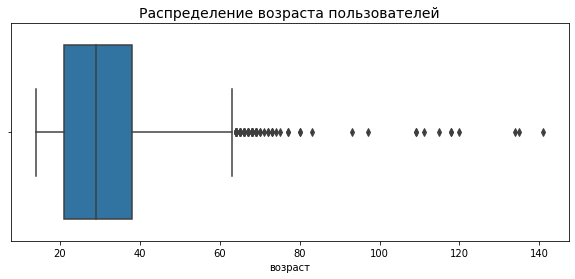

In [16]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.boxplot(membs['age_id'])

plt.title('Распределение возраста пользователей', fontdict={'size':14})
plt.xlabel('возраст');

Судя по распределению возраста пользователей, после 80 лет есть только отдельные, изолированные наблюдения — будем считать эти записи выбросами/ошибками и удалим их. Также отфильтруем пользователей моложе 18 лет — с большой вероятностью это ошибка.

In [17]:
membs = membs[(membs['age_id'] <= 80) & (membs['age_id'] >= 18)].copy()

В записях о поле есть варианты *Prefer Not to Say* и *Not Set* — заменяем на NaN

In [18]:
gender_di = {'Male':'male', 'Female':'female', 'Prefer Not to Say':np.nan, 'Not Set':np.nan}
membs['gender'] = membs['gender'].replace(gender_di)

**Предобработка данных в таблице `engagements`**

Добавляем столбец с месяцем открытия письма

In [19]:
engagements['opened_month'] = engagements['opened_date'].values.astype('datetime64[M]')

Проверяем, что одному пользователю каждая рассылка приходила только один раз.

In [20]:
campaigns = campaigns.sort_values(by=['campaign_id', 'sent_date'])

In [21]:
unique_campaigns = (engagements
                    .groupby(['consumer_id'])
                    .agg(cnt_total=('campaign_id', 'count'),
                      cnt_unique=('campaign_id', 'nunique'))
                    .reset_index()
                 )
unique_campaigns['diff'] = unique_campaigns['cnt_total'] - unique_campaigns['cnt_unique']
unique_campaigns.sort_values('diff', ascending=False).head(3)

,consumer_id,cnt_total,cnt_unique,diff
0,003GH1K9GPLAB0WG,51,51,0
9376,NXDKWDLL3IGMH64L,127,127,0
9365,NWMHRN3O9PE8R4M4,50,50,0


Проверяем, что кампании не длятся дольше месяца.

In [22]:
camp_date = (campaigns
             .groupby('campaign_id')
             .agg(campaign_date_min=('sent_date', 'min'), 
                  campaign_date_max=('sent_date', 'max'))
             .reset_index()
            )
camp_date['days'] = (camp_date['campaign_date_max'] - camp_date['campaign_date_min']) / np.timedelta64(1, 'D')
camp_date.sort_values(by=['days'], ascending=False).head(3)

,campaign_id,campaign_date_min,campaign_date_max,days
1,643100000248888,2019-08-06 09:00:00,2019-08-30 15:00:00,24.25
6,643100000262085,2019-08-14 09:00:00,2019-08-30 14:00:00,16.21
4,643100000258617,2019-08-15 09:00:00,2019-08-30 15:00:00,15.25


Для удобства далее будем считать, что одна рассылка приходит пользователю только один раз. Сопоставляем самую раннюю дату рассылки с записями о действиях пользователей, чтобы посчитать кол-во контактов в месяц.

In [23]:
engagements = engagements.merge(camp_date[['campaign_id', 'campaign_date_min']], on='campaign_id', how='left')
engagements = engagements.dropna(subset=['campaign_date_min']).reset_index(drop=True)
engagements['campaign_month'] = engagements['campaign_date_min'].values.astype('datetime64[M]')

Проверяем выбросы в кол-ве рассылок в месяц

In [24]:
sent_per_month = (engagements
                  .groupby(['consumer_id', 'campaign_month'])
                  .agg(cnt=('campaign_id', 'count'))
                  .reset_index()
                 ).merge(membs, on='consumer_id', how='left')

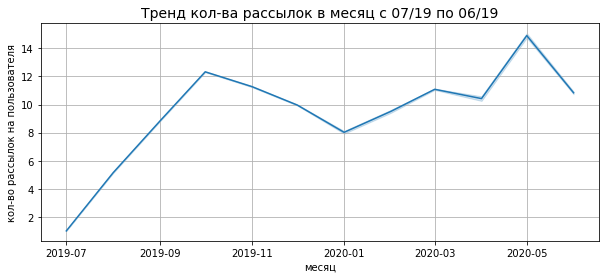

In [25]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.lineplot(x = 'campaign_month',
            y = 'cnt',
            data = sent_per_month,
            palette = 'Blues'
           )

plt.grid('major')
plt.title('Тренд кол-ва рассылок в месяц с 07/19 по 06/19', fontdict={'size':14})
plt.xlabel('месяц')
plt.ylabel('кол-во рассылок на пользователя');

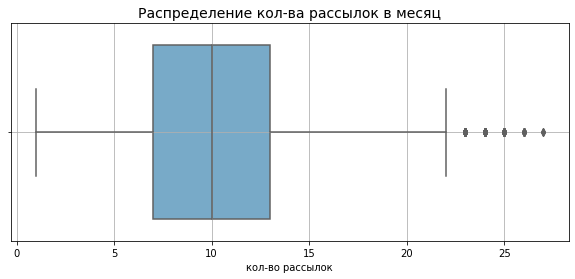

In [26]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.boxplot(y = 'cnt',
            data = sent_per_month,
            orient = 'h',
            palette = 'Blues'
           )

plt.grid('major')
plt.title('Распределение кол-ва рассылок в месяц', fontdict={'size':14})
plt.xlabel('кол-во рассылок');

In [27]:
per_95, per_99 = np.percentile(sent_per_month['cnt'], [95, 99])
users_above_per_95 = sent_per_month[sent_per_month['cnt'] > per_95]['consumer_id'].count()
users_above_per_99 = sent_per_month[sent_per_month['cnt'] > per_99]['consumer_id'].count()

print('95 и 99 персентили количества рассылок в месяц на одного пользователя: {:.0f}, {:.0f}'.format(per_95, per_99))
print('{:.0f} пользователей, получивших более {:.0f} писем и {:.0f} пользователей более {:.0f} писем'.format(users_above_per_95, per_95, users_above_per_99, per_99))

95 и 99 персентили количества рассылок в месяц на одного пользователя: 19, 22
3620 пользователей, получивших более 19 писем и 720 пользователей более 22 писем


Большинство пользователей получают менее 22 писем, но есть и такие, кто получают 27 писем в месяц. Тем не менее кажется, что в данных нет очевидных выбросов по количеству писем в месяц.

Выделяем пользователей, которые не открывали рассылки более 180 дней. Сортируем таблицу `engagements` по пользоваетлям и дате открытия и находим последнюю дату открытия рассылки. Если последняя дата меньше максимальной даты минус 180 дней, удаляем эти записи.

In [28]:
engagements = engagements.sort_values(by=['consumer_id', 'opened_date'])

last_opened_date = (engagements
                    .groupby(['consumer_id'])
                    .agg(opened_date=('opened_date', 'last'),
                        sent_date=('campaign_month', 'nunique'))
                    .reset_index()
                   )

ids_to_clear_date = (last_opened_date[last_opened_date['opened_date'] <
                                      (last_opened_date['opened_date'].max() -
                                       pd.Timedelta(days=180))]['consumer_id'])

Выделяем пользователей, которые никогда не открывали рассылки — они не попадают под условие "последняя дата открытия больше 180 дней", потому что там нет даты.

In [29]:
engagements_old = engagements[engagements['campaign_month'] < (engagements['campaign_month'].max() - pd.Timedelta(days=180))].copy()
engagements_old['date_na'] = engagements_old['opened_date'].notna()

In [30]:
opened_date_na = engagements_old.groupby('consumer_id').agg(date_na=('date_na', 'sum')).reset_index()
ids_to_clear_na = opened_date_na[opened_date_na['date_na'] == 0]['consumer_id'].unique()

Проверяем распределение кол-ва дней до открытия рассылки.

In [31]:
engagements['days_till_open'] = ((engagements['opened_date'] - engagements['campaign_date_min']) / np.timedelta64(1, 'D')).round()

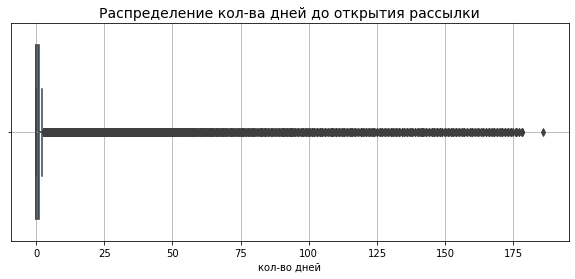

In [32]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.boxplot(engagements['days_till_open'])

plt.title('Распределение кол-ва дней до открытия рассылки', fontdict={'size':14})
plt.xlabel('кол-во дней')
plt.grid('major');

Распределение не нормальное, в данных есть пользователи, которые приближаются к границе "не открывал рассылки 180 дней". Но не думаю, что эти записи стоит удалять — иначе мы искусственно завысим % открытий рассылок 

Фильтрую пользователей, которые а)никогда не открывали рассылки, б)не открывали рассылки более 180 дней и рассылки, которые не были доставлены.

In [33]:
delivered_only = (engagements['delivered'] == 1)
opened_date_na = (~engagements['consumer_id'].isin(ids_to_clear_na))
opened_date_old = (~engagements['consumer_id'].isin(ids_to_clear_date))

engagements = engagements[delivered_only & opened_date_na & opened_date_old]

**Общий вывод по пердобработке**

- В таблице `membs` оставили записи о пользователях возрастом старше 18ти лет и моложе 80ти. А в столбце *gender* варианты Prefer Not to Say и Not Set — заменили на NaN.
-  В таблице `engagements` сопоставили каждому id кампании самую раннюю дату ее рассылки — далее делаем допущение, что пользователь получил рассылку именно в эту дату.
- Проверили наличие выбросов в количестве рассылок на пользователя — большинство получают меньше 22 писем в месяц, но есть и те кто получают 27. Не считаем это аномальной активностью.
- Удалили из таблицы `engagements` записи о пользователях, которые не открывали рассылки более 180 дней и рассылках, которые не были доставлены.

<a href="#back">В начало</a>

<article id="part3">
<h2>Шаг 3. Анализ данных
    
</article>

**Как соотносятся open rate и количество рассылок?**

In [34]:
#группируем события по id пользователя и месяцу кампании и считаем open rate
campaign_count = (engagements
                  .groupby(['consumer_id', 'campaign_month'])
                  .agg(sum_opened=('opened', 'sum'),
                       sum_sent=('sent', 'sum'))
                  .reset_index()
                 )
campaign_count['open_rate'] = campaign_count['sum_opened'] / campaign_count['sum_sent']

In [35]:
#считаем средний open rate
mean_open_rate = (campaign_count
                  .groupby(['sum_sent'])
                  .agg(sum_sent=('sum_sent', 'sum'),
                       sum_opened=('sum_opened', 'sum')
                  #.reset_index()
                 ))
mean_open_rate['open_rate'] = mean_open_rate['sum_opened'] / mean_open_rate['sum_sent']

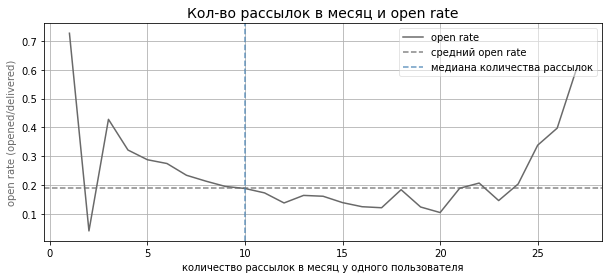

In [36]:
x = mean_open_rate.index
y = mean_open_rate['open_rate']

fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(x, y, color = 'dimgrey', label = 'open rate')

ax.axhline(y=mean_open_rate['open_rate'].median(), color = 'dimgrey', linestyle='--', alpha = 0.8, label = 'средний open rate')
ax.axvline(x=sent_per_month['cnt'].median(), color = 'steelblue', linestyle='--', alpha = 0.8, label = 'медиана количества рассылок')


ax.set_xlabel('количество рассылок в месяц у одного пользователя')
ax.set_ylabel('open rate (opened/delivered)', color = 'dimgrey')
ax.set_title('Кол-во рассылок в месяц и open rate', fontdict={'size':14})
ax.legend(fancybox=True, framealpha=0.5, loc='upper right')

plt.grid('major');

Интересно распределется % открытий писем: письма чаще открывают либо если их мало (<5), либо если много (>25).

Судя по доле пользователей, открывших рассылки, есть достаточное кол-во людей, которые получают 20 и более писем в месяц и не испытывают дискомфорта: open rate очень высокий (>=40%).

**Есть ли зависимость между кол-вом рассылок в месяц и явным оттоком (Unsubscribed = 1)?**

In [37]:
voluntary_churn = (engagements
                   .groupby(['consumer_id', 'campaign_month'])
                   .agg(sum_unsub=('unsubscribed', 'sum'),
                        sum_sent=('sent', 'sum'))
                   .reset_index()
                 )
voluntary_churn['unsubscribed_rate'] = voluntary_churn['sum_unsub'] / voluntary_churn['sum_sent']

In [38]:
voluntary_churn['sum_unsub'].sum() / voluntary_churn['sum_sent'].sum() * 100

0.058370694319408924

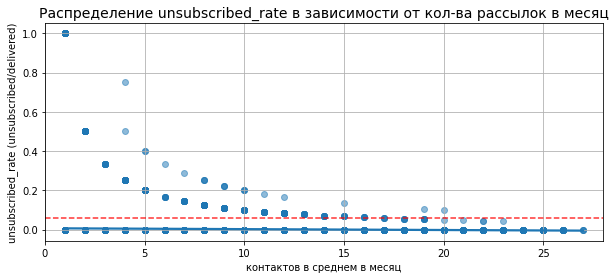

In [39]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.regplot(x = 'sum_sent',
            y = 'unsubscribed_rate',
            data = voluntary_churn,
            scatter_kws={'alpha':0.5}
           )

ax.axhline(y=(voluntary_churn['sum_unsub'].sum() / voluntary_churn['sum_sent'].sum() * 100), color = 'red', linestyle='--', alpha = 0.8, label = 'mean')

plt.xlim(voluntary_churn['sum_sent'].min()-1, voluntary_churn['sum_sent'].max()+1)
plt.title('Распределение unsubscribed_rate в зависимости от кол-ва рассылок в месяц', fontdict={'size':14})
plt.xlabel('контактов в среднем в месяц')
plt.ylabel('unsubscribed_rate (unsubscribed/delivered)')
plt.grid('major');

Да, зависимость прослеживается, но немного неожиданная: чем больше писем получает пользователь, тем меньше % отписок.

**Есть ли зависимость между кол-вом рассылок и неявным оттоком (Opened = 0)?**

In [40]:
involuntary_churn = (engagements
                   .groupby(['consumer_id', 'campaign_month'])
                   .agg(sum_opened=('opened', 'sum'),
                        sum_sent=('sent', 'sum'))
                   .reset_index()
                 )
involuntary_churn['open_rate'] = involuntary_churn['sum_opened'] / involuntary_churn['sum_sent']

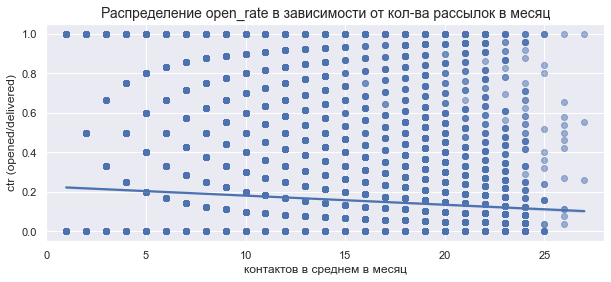

In [41]:
sns.set(rc = {'figure.figsize': (10, 4)})

sns.regplot(x = 'sum_sent',
            y = 'open_rate',
            data = involuntary_churn,
            scatter_kws={'alpha':0.5}
           )

plt.xlim(involuntary_churn['sum_sent'].min()-1, involuntary_churn['sum_sent'].max()+1)
plt.title('Распределение open_rate в зависимости от кол-ва рассылок в месяц', fontdict={'size':14})
plt.xlabel('контактов в среднем в месяц')
plt.ylabel('ctr (opened/delivered)')
plt.grid('major');

Да, скорее всего есть отрицательная зависимость, но данные нужно очистить от шума.

Для проверки гипотезы о "пассивной отписке" выделем пользователей, которым приходило значительно отличающееся кол-во рассылок в месяц: интерквартильный размах кол-ва рассылок больше, чем среднее

In [42]:
#выделяем уникальные id пользователей, по которым есть записи
consumer_id_unique = engagements[['consumer_id']].drop_duplicates().reset_index(drop=True)

In [43]:
#для каждого id рассчитываем q1, q3 и среднее кол-во рассылок
for consumer_id in consumer_id_unique['consumer_id']:
    consumer_id_unique.loc[consumer_id_unique['consumer_id'] == consumer_id, 'q1'] = campaign_count.loc[campaign_count['consumer_id'] == consumer_id, 'sum_sent'].quantile(0.25)
    consumer_id_unique.loc[consumer_id_unique['consumer_id'] == consumer_id, 'q3'] = campaign_count.loc[campaign_count['consumer_id'] == consumer_id, 'sum_sent'].quantile(0.75)
    consumer_id_unique.loc[consumer_id_unique['consumer_id'] == consumer_id, 'mean'] = campaign_count.loc[campaign_count['consumer_id'] == consumer_id, 'sum_sent'].mean()

In [44]:
#рассчитываем интерквартильный размах
consumer_id_unique['iqr'] = consumer_id_unique['q3'] - consumer_id_unique['q1']
#фильтруем пользователей для которых iqr*0.9 < mean
consumer_id_final = consumer_id_unique[consumer_id_unique['iqr'] >= consumer_id_unique['mean']*0.9]['consumer_id']

In [45]:
scatter = campaign_count[campaign_count['consumer_id'].isin(consumer_id_final)]

In [46]:
lr = LinearRegression()

X = scatter['sum_sent']
y = scatter['open_rate']

lr.fit(X.values.reshape(-1, 1), y.values.reshape(-1, 1))

y_pred = lr.predict(X.values.reshape(-1, 1))

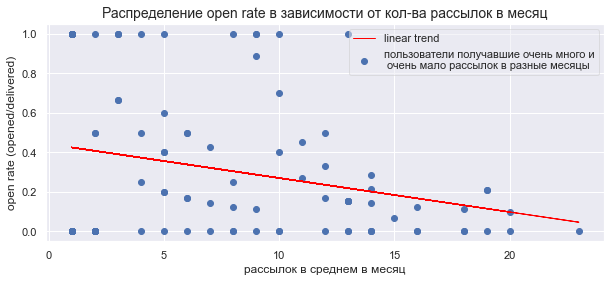

In [47]:
fig, ax = plt.subplots(figsize = (10, 4))

plt.scatter(X, y, label='пользователи получавшие очень много и\n очень мало рассылок в разные месяцы')
plt.plot(X, y_pred, color='red', linewidth=1, label='linear trend')

plt.legend(fancybox=True, framealpha=0.5)
plt.title('Распределение open rate в зависимости от кол-ва рассылок в месяц', fontdict={'size':14})
plt.xlabel('рассылок в среднем в месяц')
plt.ylabel('open rate (opened/delivered)');

Если посмотреть на пользователей, которые в разное время получали значительно отличающееся количество писем, то будет видно, что с ростом количества рассылок open rate неумолимо снижается.

**Общий вывод по анализу данных**

- Письма чаще открывают либо если их мало (<5), либо если их много (>25).
- Зависимость между количеством рассылок в месяц и  долей отписавшихся прослеживается, но немного неожиданная: чем больше писем получает пользователь, тем меньше % отписок. Возможно, это говорит о том, что те пользователи, которые получают >10 писем в месяц осознанно подписались на них. 
- Если посмотреть на пользователей, которые в разное время получали значительно отличающееся количество писем, то будет видно, что с ростом количества рассылок open rate неумолимо снижается.

<a href="#back">В начало</a>

<article id="part4">
<h2>Шаг 4. Расчет оптимального количества рассылок
</article>

Разделим пользователей на кластеры и в зависимости от кластера рассчитаем оптимальное количество рассылок

In [48]:
#в таблицу campaign_count добавляем данные о переходах и отписках
campaign_count = campaign_count.merge(engagements
                                      .groupby(['consumer_id', 'campaign_month'])
                                      .agg(sum_clicked=('clicked', 'sum'),
                                           sum_unsubscribed=('unsubscribed', 'sum')),
                                      on=['consumer_id', 'campaign_month'],
                                      how='left')

In [49]:
#группируем в сводную таблицу данные о взимодействиях пользователей с рассылками
for_clusters = (campaign_count
                .groupby('consumer_id')
                .agg(sent=('sum_sent', 'mean'),
                     opened=('sum_opened', 'mean'),
                     clicked=('sum_clicked', 'mean'),
                     unsubscribed=('sum_unsubscribed', 'mean')
                    )
               )

In [50]:
#добавляем информацию о возрасте и поле (заменяем male/female на 0/1)
for_clusters = for_clusters.merge(membs[['consumer_id', 'age_id', 'gender']], on=['consumer_id'], how='left')

In [51]:
#удаляем NA и убираем id пользователя в индекс
for_clusters_short = (for_clusters
                      .set_index('consumer_id')[['opened', 
                                                 #'sent',
                                                 'age_id',
                                                 'clicked',
                                                 'unsubscribed']]
                      .dropna())

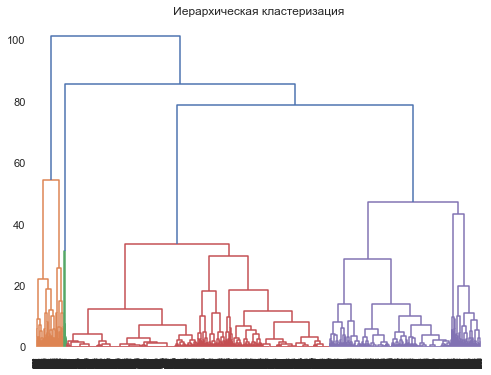

In [52]:
#стандартизируем данные
scaler = StandardScaler()
x_sc = scaler.fit_transform(for_clusters_short)

#строим матрицу расстояний
linked = linkage(x_sc, method = 'ward')

#строим дендрограмму
plt.figure(figsize=(8, 6))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Модель предлагает разделить пользователей на 4 кластера

In [53]:
#задаём модель и число кластеров
scaler = StandardScaler()
x_sc = scaler.fit_transform(for_clusters_short)
linked = linkage(x_sc, method = 'ward')
    
#прогнозируем кластеры
k=4
cluster = fcluster(linked, k, criterion='maxclust')
for_clusters_short['cluster'] = cluster

In [54]:
#добавляем информацию о кластере в изначальную таблицу 
for_clusters = for_clusters.merge(for_clusters_short.reset_index()[['consumer_id', 'cluster']], on='consumer_id', how='left')

In [55]:
#смотрим статистику по кластерам
clust_stat = (for_clusters
              .pivot_table(index='cluster', 
                           values=['sent', 
                                   'opened',
                                   'clicked',
                                   'unsubscribed',
                                   'age_id'],
                           aggfunc='mean')
              .reset_index()
              .merge(for_clusters
                     .groupby('cluster')
                     .agg(unique_users=('cluster', 'count'))
                     .reset_index(), on='cluster', how='left')
             )
clust_stat = clust_stat.rename(columns={"sent": "avg_sent"})
clust_stat['avg_sent'] = round(clust_stat['avg_sent'])

(clust_stat
 .set_index('cluster')
 .T
 .style
 .format("{:.1f}")
 .background_gradient(cmap = 'Blues', axis=1)
)

cluster,1.0,2.0,3.0,4.0
age_id,38.2,33.8,25.4,41.8
clicked,0.9,0.1,0.0,0.2
opened,7.5,1.7,0.5,0.9
avg_sent,12.0,2.0,6.0,8.0
unsubscribed,0.0,1.1,0.0,0.0
unique_users,351.0,25.0,3151.0,1814.0


Кажется кластеры действительно сильно различаются:
- 1 кластер: получают в среднем 12 рассылок, больше половины из них открывают и из 1го письма переходят на сайт/приложение;
- 2 кластер: получают 2 письма и от 1 отписываются;
- 3 кластер: самый крупный кластер и самый молодой: в среднем пользователи получают 6 писем, но никаких действий не совершают;
- 4 кластер: поллучают 8 писем, одно из которых открывают;

In [56]:
#добавляем рекомендованное кол-во рассылок в таблицу с id пользователей
for_clusters = for_clusters.merge(clust_stat[['cluster', 'avg_sent']], on='cluster', how='left')

In [57]:
#выделяем в таблицу информацию о пользователях и рекомендованному количеству рассылок
optimal_campaign_num = membs[['consumer_id']].merge(for_clusters[['consumer_id', 'avg_sent']], on='consumer_id', how='left')
#пользователям, для которых не нашлой кол-ва рассылок присваиваем 0 
optimal_campaign_num.loc[(optimal_campaign_num['avg_sent'].isna()), 'avg_sent'] = 0
#добавляем столбец с информацией о том, что значение кол-ва рассылок выше среднего
optimal_campaign_num['above_average'] = (optimal_campaign_num['avg_sent'] > optimal_campaign_num['avg_sent'].mean()).astype('int')

**Методология расчета оптимального количества рассылок **

- Предобработка данных о взаимодействиях с рассылками:
    - удалены пользователи, которые не открывали рассылки более 180 дней;
    - удалены записи о недоставленных рассылках;
- Разделение пользователей на кластеры с помощью агломеративной иерархической кластеризации по следующим признакам:
    - количество открытых рассылок, 
    - количество переходов из рассылок, 
    - количество unsubscribed
    - возраст пользователя
- Рекомендованное количество рассылок для каждого кластера равно среднему количеству рассылок по данному кластеру;
- Рекомендованное количество рассылок для пользователей, которые были отфильтрованы на этапе предобработки, равно 0.


<a href="#back">В начало</a>

<article id="part5">
<h2>Шаг 5. Проверка гипотез
</article>

**1. Гипотеза о “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться**
- **H0**: Конверсия писем из *Delivered* в *Opened* у группы пользователей, получивших рассылок больше чем в среднем, такая же как у пользователей, получивших рассылок меньше чем в среднем.
- **H1**: Конверсия писем из *Delivered* в *Opened* у группы пользователей, получивших рассылок больше чем в среднем, статистически значимо отличается от конверсии у пользователей, получивших рассылок меньше чем в среднем.

In [59]:
campaign_count = campaign_count.merge(consumer_id_unique[['consumer_id', 'mean']], on='consumer_id', how='left')

Средний open_rate для группы с маленьким кол-вом рассылок 0.21
Среднее кол-во рассылок для группы с маленьким кол-вом рассылок 9
Средний open_rate для группы с большим кол-вом рассылок 0.15
Среднее кол-во рассылок для группы с большим кол-вом рассылок 15


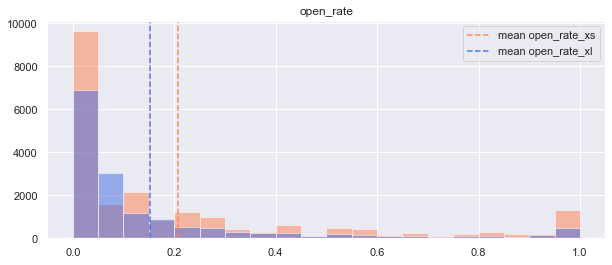

In [60]:
open_rate_xs = campaign_count[campaign_count['sum_sent'] < campaign_count['mean']]['open_rate']
open_rate_xl = campaign_count[campaign_count['sum_sent'] > campaign_count['mean']]['open_rate']

print('Средний open_rate для группы с маленьким кол-вом рассылок {:.2f}'.format(open_rate_xs.mean()))
print('Среднее кол-во рассылок для группы с маленьким кол-вом рассылок {:.0f}'.format(campaign_count[campaign_count['sum_sent'] < campaign_count['mean']]['sum_sent'].mean()))
print('Средний open_rate для группы с большим кол-вом рассылок {:.2f}'.format(open_rate_xl.mean()))
print('Среднее кол-во рассылок для группы с большим кол-вом рассылок {:.0f}'.format(campaign_count[campaign_count['sum_sent'] > campaign_count['mean']]['sum_sent'].mean()))


plt.figure(figsize=(10, 4))
plt.title('open_rate')

open_rate_xs.hist(alpha=0.5, bins = 20, color='coral')
open_rate_xl.hist(alpha=0.5, bins = 20, color='royalblue')

plt.axvline(open_rate_xs.mean(), color='coral', alpha=0.9, linestyle='dashed')
plt.axvline(open_rate_xl.mean(), color='royalblue', alpha=0.9, linestyle='dashed')

plt.legend(['mean open_rate_xs', 'mean open_rate_xl']);


In [61]:
#считаем кол-во уникальных пользователей, которые открыли и получили рассылки по группам пользователей:
#1 — получали в месяц рассылок меньше чем mean, 2 — получали в месяц рассылок больше чем mean
suc_1 = campaign_count[(campaign_count['sum_sent'] < campaign_count['mean']) & (campaign_count['sum_opened'] > 0)]['consumer_id'].nunique()
tot_1 = campaign_count[(campaign_count['sum_sent'] < campaign_count['mean']) & (campaign_count['sum_sent'] > 0)]['consumer_id'].nunique()

suc_2 = campaign_count[(campaign_count['sum_sent'] > campaign_count['mean']) & (campaign_count['sum_opened'] > 0)]['consumer_id'].nunique()
tot_2 = campaign_count[(campaign_count['sum_sent'] > campaign_count['mean']) & (campaign_count['sum_sent'] > 0)]['consumer_id'].nunique()

In [62]:
alpha = 0.05 # критический уровень статистической значимости

#доля успехов
p1 = suc_1/tot_1
p2 = suc_2/tot_2
p_combined = (suc_1 + suc_2) / (tot_1 + tot_2)
difference = p1 - p2
    
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/tot_1 + 1/tot_2))

#задаем стандартное нормальное распределение
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value)))

print('p-value: {:.5f}'.format(p_value))
if (p_value < alpha):
    print("Отвергаем H0: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть H0, нет оснований считать доли разными")

p-value: 0.00000
Отвергаем H0: между долями есть значимая разница


Проверяем гипотезу о равенстве долей с помощью z-test: p-value меньше критического уровня значимости alpha (0.05), значит нулевую гипотезу отвергаем.

Это значит, что пользователи, которые получали много рассылок (15 в месяц) открывали их менее часто, чем пользователи, которым приходило не так много писем.

**Общий вывод по проверке гипотез**

Гипотезу о пассивной отписке проверяли с помощью z-test. Нулевую гипотезу отвергли, так как p-value меньше критического уровня значимости alpha (0.05). Это значит, что пользователи, которые получали много рассылок (15 в месяц) открывали их статистически значимо менее часто, чем пользователи, которым приходило не так много писем (9 в месяц).


<a href="#back">В начало</a>

<article id="part6">
<h2>Шаг 6. Общий вывод
</article>

Для анализа были доступны данные когорты пользователей, зарегистрировавшихся 2019/07/02: всего около 14т id, записи об их взаимодействиях с рассылками (факт получения, открытия, перехода на сайт/приложение).

- В среднем пользователи получали 10 писем в месяц, из которых только 2 открывали. Причем, судя по графику зависимости доли открытых писем от общего количества полученных, пользователи смотрели рассылки, либо когда их приходило очень мало, либо очень много.
- К счастью, здравый смысл победил: на корректно очищенных данных стало видно, что с ростом количества рассылок, доля открытых писем все-таки снижается. Эта зависимость также подтвердилась статистически: пользователи, которые получали много рассылок (15 в месяц) открывали их статистически значимо менее часто, чем пользователи, которым приходило не так много писем (9 в месяц).
- С помощью кластерного анализа в данных было выделено 4 группы пользователей, для которых могут быть рекомендованы различные стратегии коммуникации — см таблицу.